In [1]:
using Plots, Printf, DelimitedFiles, BenchmarkTools, FFTW
using Revise
using MDToolbox
ENV["COLUMNS"] = 130

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/MgvIv/src/Revise.jl:1167


130

In [2]:
q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/3gb1.pdb")

32x855 TrjArray
| A                          | A                          |  …   A                          | A                          |
| 1MET                       | 1MET                       |  …   56GLU                      | 56GLU                      |
| 1N                         | 2CA                        |  …   854HG2                     | 855HG3                     |
|   -13.15    -1.71     5.51 |   -12.20    -2.85     5.70 |  …      11.40     2.98    -5.63 |    10.24     2.24    -4.53 |
|   -13.16    -2.75     4.19 |   -12.38    -3.43     5.26 |         10.40     2.85    -4.61 |    10.29     1.79    -3.20 |
|   -13.26    -2.20     5.12 |   -12.23    -3.26     5.29 |         12.80     2.83    -6.07 |    11.09     3.24    -6.13 |
|   -12.45    -4.30     6.28 |   -12.25    -3.22     5.28 |         10.45     1.46    -3.73 |    11.75     2.57    -3.31 |
|   -13.05    -1.52     5.31 |   -12.15    -2.68     5.56 |         10.53     2.31    -5.07 |    10.46     1.51    -3.50 |


In [3]:
model_array = model_array["atomname CA"];
decenter!(model_array)

32x56 TrjArray
| A                          | A                          |  …   A                          | A                          |
| 1MET                       | 2THR                       |  …   55THR                      | 56GLU                      |
| 1CA                        | 2CA                        |  …   55CA                       | 56CA                       |
|   -12.62    -3.33     5.86 |    -8.98    -3.02     6.98 |  …       8.54    -2.95    -4.18 |    11.07    -0.36    -5.43 |
|   -12.80    -3.92     5.42 |    -9.28    -3.12     6.70 |          8.52    -2.71    -4.02 |    11.02    -0.04    -5.16 |
|   -12.65    -3.75     5.44 |    -9.13    -3.18     6.84 |          8.55    -2.65    -4.07 |    10.83     0.14    -5.33 |
|   -12.68    -3.72     5.44 |    -9.14    -3.08     6.73 |          8.56    -3.04    -4.13 |    11.25    -0.59    -5.31 |
|   -12.58    -3.17     5.72 |    -8.95    -2.93     6.94 |          8.63    -3.03    -4.08 |    11.25    -0.52    -5.32 |
|

# 並進の計算

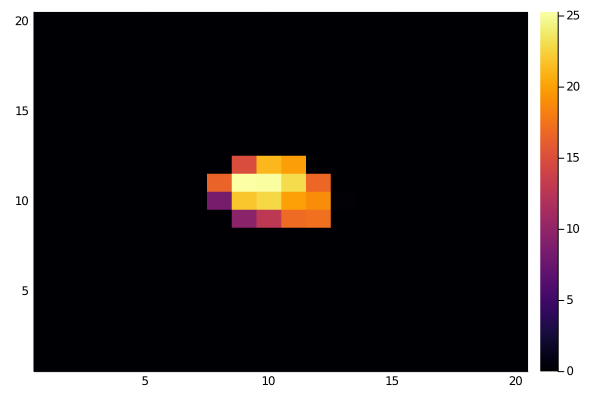

In [4]:
pdbRotated = MDToolbox.rotate(model_array[1, :], q_array[7, :])
calculated = afmize(pdbRotated, MDToolbox.defaultConfig())
observed = calculated
heatmap(observed)

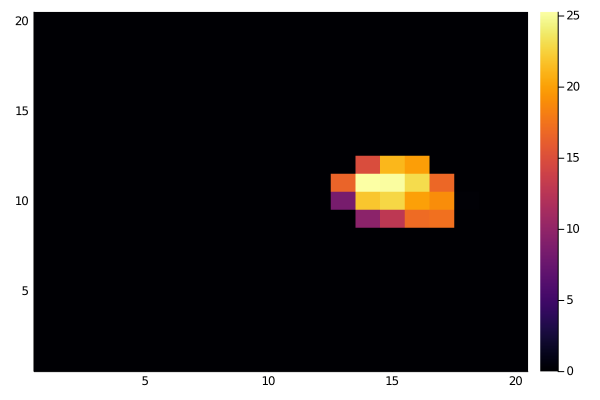

In [5]:
observed_translated = translateafm(observed, (0, 5))
heatmap(observed_translated)

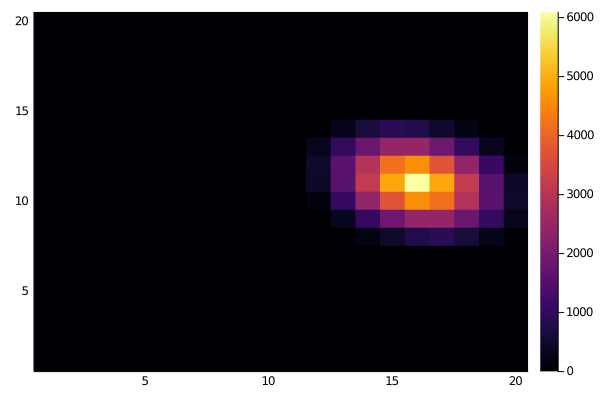

In [6]:
#observed_translated .= observed_translated .- 100.0
C_o  = sum(observed_translated)
C_c  = sum(calculated)
C_oc = sum(observed_translated .* calculated)
C_cc = sum(calculated.^2)
C_oo = sum(observed_translated.^2)
C_oc_dxdy = real.(ifftshift(ifft(fft(observed_translated).*conj.(fft(calculated)))))
heatmap(C_oc_dxdy)

In [7]:
C_oc_dxdy

20×20 Array{Float64,2}:
 -2.47553e-13  -6.06389e-14   9.84577e-14   2.29941e-13   3.17813e-13  …    -3.72366e-13    -3.46354e-13   -3.31549e-13
 -1.88578e-13  -4.66218e-14   8.23898e-14   1.79194e-13   2.41332e-13       -5.43874e-14    -1.25403e-13   -1.96296e-13
 -2.11004e-13  -8.1809e-14    4.89658e-14   1.20453e-13   1.74895e-13       -4.08666e-13    -3.67465e-13   -3.07087e-13
 -1.5703e-14    3.39501e-14   1.26209e-13   2.08176e-13   2.69088e-13       -2.27481e-13    -1.39479e-13   -4.78882e-14
  7.01321e-14   5.95831e-14   3.24863e-14  -2.37679e-14  -7.97e-14          -5.51114e-14     3.19563e-14    8.12093e-14
  2.02078e-13   2.00034e-13   1.71808e-13   1.50063e-13   1.17031e-13  …     5.10107e-14     1.28927e-13    1.93808e-13
  2.16001e-13   9.40375e-14   3.27316e-15  -2.91001e-14  -8.04688e-14        2.57772e-13     2.97827e-13    2.96494e-13
  2.91038e-13   2.46388e-13   2.18279e-13   2.54659e-13   1.45519e-13      618.993         257.388          1.97863e-13
  7.27596e-14   

In [8]:
maximum(C_oc_dxdy)

6098.916830447093

In [9]:
C_oo

6098.916830447093

# Posteriorの計算

In [10]:
log(0)
log(eps(Float64))

-36.04365338911715

In [11]:
npix = Float64(size(observed_translated, 1) * size(observed_translated, 2))
#logprob = 0.5 .* (3.0 .- npix) .* log.(npix .* (C_cc .* C_oo .- C_oc_dxdy.^2) .+ 2.0 .* C_o .* C_oc_dxdy .* C_c .- C_cc .* C_o.^2 .- C_oo .* C_c.^2) .+ (0.5 .* npix .- 2.0) .* log.((npix .- 2.0) .* (npix .* C_cc .- C_c.^2))
log01 = npix .* (C_cc .* C_oo .- C_oc_dxdy.^2) .+ 2.0 .* C_o .* C_oc_dxdy .* C_c .- C_cc .* C_o.^2 .- C_oo .* C_c.^2
log01[log01 .<= 0.0] .= eps(Float64)
log02 = (npix .- 2.0) .* (npix .* C_cc .- C_c.^2)
log02 = log02 <= 0 ? eps(Float64) : log02
logprob = 0.5 .* (3.0 .- npix) .* log.(log01) .+ (0.5 .* npix .- 2.0) .* log.(log02)

20×20 Array{Float64,2}:
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709  …  -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709  …  -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.709   -543.709  -543.709  -543.709  -543.709  -543.709
 -543.709  -543.709  -543.709  -543.709  -543.709  -543.709     -543.784   -542.55   -541.579  -543.23   -54

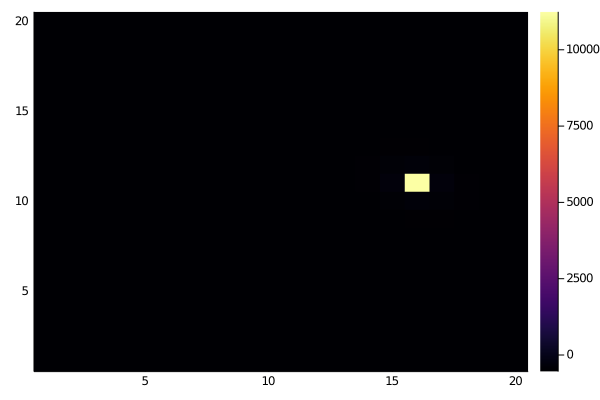

In [12]:
heatmap(logprob)

In [13]:
maximum(logprob)

11243.990212966017